In [4]:
%matplotlib notebook

In [7]:
import numpy as np
import random
import itertools
from graph_tool import Graph, GraphView
from graph_tool.draw import graph_draw
from tqdm import tqdm

from matplotlib import pyplot as plt

from viz_helpers import lattice_node_pos
from minimum_steiner_tree import min_steiner_tree
from cascade_generator import si, observe_cascade
from eval_helpers import infection_precision_recall
from graph_helpers import remove_filters, load_graph_by_name

from inference import infer_infected_nodes
from query_selection import RandomQueryGenerator, OurQueryGenerator, PRQueryGenerator
from experiment import gen_input, one_round_experiment

In [33]:
graph_name = 'lattice'
g = load_graph_by_name(graph_name)

In [9]:
if False:
    import graph_tool as gt
    pos = gt.draw.sfdp_layout(gv)
    vertex_text = g.new_vertex_property('string')
    for v in g.vertices():
        vertex_text[v] = str(v)
    gt.draw.graph_draw(gv, pos=pos, vertex_text=vertex_text)

In [26]:
def one_combined_round(g, n_queries, obs, c):
    print('n_queries', n_queries)
    scores = []
    # for rand method
    gv = remove_filters(g)
    rand_gen = RandomQueryGenerator(gv, obs)
    score = one_round_experiment(gv, obs, c, rand_gen, 'random', n_queries)
    scores.append(score)

    print('random done')
    
    # for our method
    gv = remove_filters(g)
    our_gen = OurQueryGenerator(gv, obs, num_spt=100, num_stt=50,
                                method='entropy',
                                use_resample=True)
    score = one_round_experiment(gv, obs, c, our_gen, 'ours', n_queries, log=False)
    scores.append(score)    
    
    print('our done')
    
    # for our pagerank
    gv = remove_filters(g)
    pr_gen = PRQueryGenerator(gv, obs)
    score = one_round_experiment(gv, obs, c, pr_gen, 'pagerank', n_queries)
    scores.append(score)
    
    print('pr done')
    return scores
    

In [30]:
from joblib import Parallel, delayed
scores = {
    'random': [],
    'pagerank': [],
    'ours': []
}

n_rounds = 1
n_queries = 1


sc = Parallel(n_jobs=4)(delayed(one_combined_round)(g, n_queries, *gen_input(g, stop_fraction=0.25))
                     for i in tqdm(range(n_rounds)))
for rd, our, pr in sc:
    scores['random'].append(rd)
    scores['ours'].append(our)
    scores['pagerank'].append(pr)



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

n_queries 1
random done


our done
pr done


In [31]:
rand_mean_scores = np.mean(np.asarray(scores['random']), axis=0)
our_mean_scores = np.mean(np.asarray(scores['ours']), axis=0)
pr_mean_scores = np.mean(np.asarray(scores['pagerank']), axis=0)

<IPython.core.display.Javascript object>


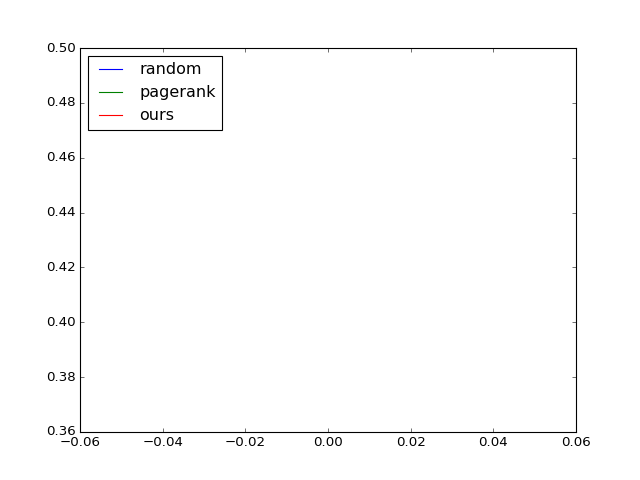

In [36]:
rand_prec, rand_rec = zip(*rand_mean_scores)
pr_prec, pr_rec = zip(*pr_mean_scores)
our_prec, our_rec = zip(*our_mean_scores)
fig = plt.figure()
fig.clf()
plt.plot(rand_prec)
plt.plot(pr_prec)
plt.plot(our_prec)
plt.legend(['random', 'pagerank', 'ours'], loc='upper left')
fig.savefig('figs/percision-{}.pdf'.format(graph_name))

<IPython.core.display.Javascript object>


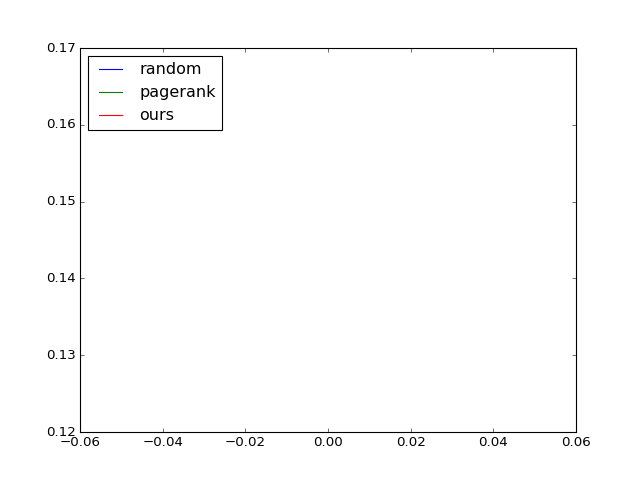

In [37]:
plt.figure()
plt.plot(rand_rec)
plt.plot(pr_rec)
plt.plot(our_rec)
plt.legend(['random', 'pagerank', 'ours'], loc='upper left')
fig.savefig('figs/recall-{}.pdf'.format(graph_name))